# Convnet with small dataset

That we need large dataset for high dimensional data, like image, is well known. but it is quite common to do some projects with small 

dataset in practice because getting large dataset is quite expensive and sometimes impossible. In workflow for this, we usually take 

steps to build small networks and small networks with data augmentation, use pretrained networks, which is powerful in CNN because of 

its feature (parameter-share) and lastly, pretrained networks with fine tune. Let's do these 4 things step by step.

## 1. Data


In [1]:
import os, shutil

In [2]:
original_dataset_dir = ('C:/python/dogs-vs-cats/train')
base_dir = ('C:/python/dogs-vs-cats_small')

os.mkdir(base_dir) # Create file

# Directory for each dataset

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
dev_dir = os.path.join(base_dir,'dev')
os.mkdir(dev_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory for dogs and cats

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

dev_cats_dir = os.path.join(dev_dir, 'cats')
os.mkdir(dev_cats_dir)
dev_dogs_dir = os.path.join(dev_dir, 'dogs')
os.mkdir(dev_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 jpg files at train - cat
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src,dst)

# 1000 ~ 1500 at dev
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(dev_cats_dir, fname)
    shutil.copyfile(src,dst)

# 1500 ~ 2000 at test
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src,dst)

# first 1000 - dog
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src,dst)
    
# 1000 ~ 1500 at dev
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(dev_dogs_dir, fname)
    shutil.copyfile(src,dst)
    
# 1500 ~ 2000 at test
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src,dst)

## 2. Model 1
### 2.1 Small networks
##### Build

In [3]:
from keras import models
from keras import layers
from keras.layers import Dense, Activation, BatchNormalization, Dropout

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(Activation('relu'))

model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
__________

##### Compile

In [5]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(lr=1e-4),
               metrics=['acc'])

### 2.2 Data preprocessing

In image classifier process, we need to preprocess data. We have jpeg files, hence,

- Read files
- Transform jpeg to RGB pixel value
- Transform to tensor
- Divide with 255 

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
dev_generator = test_datagen.flow_from_directory(dev_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Generator makes batch infinitely. We need to use break at somewhere.

In [7]:
for data_batch, labels_batch in train_generator:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(20, 150, 150, 3)
(20,)


### 2.3 Training

By using fit_generator other than fit, we can use data genorated by genorator we defined.

And importantly, because data is created infinitely, we need to set steps_per_epoch to define one epoch for model.

We have 2000 samples with 20 batch, hence, 100 steps per epoch.

And like train set, we need to define steps for validation set.

We have 1000 samples with 20 batch, hence, 50 steps.


In [8]:
history =  model.fit_generator(train_generator,
                               steps_per_epoch=100,
                               epochs=30,
                               validation_data=dev_generator,
                               validation_steps=50)

Epoch 1/30
100/100 [==============================] - 271s 3s/step - loss: 0.6897 - acc: 0.5290 - val_loss: 0.6733 - val_acc: 0.5780
Epoch 2/30
100/100 [==============================] - 200s 2s/step - loss: 0.6589 - acc: 0.6050 - val_loss: 0.6409 - val_acc: 0.6270
Epoch 3/30
100/100 [==============================] - 197s 2s/step - loss: 0.6061 - acc: 0.6740 - val_loss: 0.6063 - val_acc: 0.6710
Epoch 4/30
100/100 [==============================] - 191s 2s/step - loss: 0.5637 - acc: 0.7110 - val_loss: 0.6014 - val_acc: 0.6790
Epoch 5/30
100/100 [==============================] - 197s 2s/step - loss: 0.5386 - acc: 0.7325 - val_loss: 0.5885 - val_acc: 0.6910
Epoch 6/30
100/100 [==============================] - 193s 2s/step - loss: 0.5166 - acc: 0.7340 - val_loss: 0.5690 - val_acc: 0.6900
Epoch 7/30
100/100 [==============================] - 192s 2s/step - loss: 0.4802 - acc: 0.7710 - val_loss: 0.5607 - val_acc: 0.7100
Epoch 8/30
100/100 [==============================] - 194s 2s/step - 

### 2.4 Evaluate with graph

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np
sns.set(style="darkgrid")

In [34]:
epochs = range(1, len(acc) + 1)
acc = history.history['acc']
dev_acc = history.history['val_acc']
loss = history.history['loss']
dev_loss = history.history['val_loss']

In [35]:
model_1_result = pd.DataFrame({'epochs': epochs, 'acc': acc, 'dev_acc': dev_acc, 'loss': loss, 'dev_loss':dev_loss})

<Figure size 432x288 with 0 Axes>

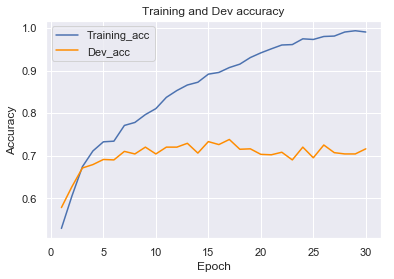

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(epochs, acc, 'b', label='Training_acc')
plt.plot(epochs, dev_acc, 'darkorange', label='Dev_acc')
plt.title("Training and Dev accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()

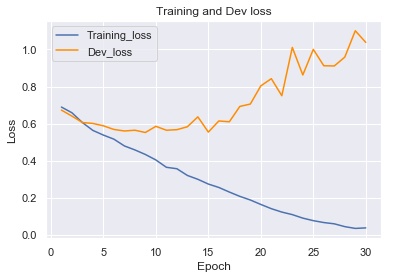

In [52]:
plt.plot(epochs, loss, 'b', label='Training_loss')
plt.plot(epochs, dev_loss, 'darkorange', label='Dev_loss')
plt.title("Training and Dev loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()